# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [4]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
import pickle


%matplotlib inline

# Read the files as input and put them as records and save into portfolio, profile and transcript data frame
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploration

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


# Cleaning
## 1. May need to split out channels into separate columns for each.
## 2. Other columns seem organized.

In [407]:
def cportfolio(x):
    
    '''
    This function will clean the portfolio data set
    
    Input Parameter:
    Enter the JSON file to be cleaned
    
    OUTPUT Parameter:
    It will output the cleaned dataframe for portfolio
    
    '''
    # Convert from Day to Hour
    #Make a backup copy of the dataframe without overwriting the original
    cportfolio = x.copy()
    # Multiply by 24 to get 24 hours
    cportfolio['duration'] = cportfolio['duration'] * 24
    
    # One Hot Encoding So it Displays 1 if it applies and 0 if it does not apply and also span out to multiple columns
    
    cportfolio['web'] = cportfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cportfolio['email'] = cportfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cportfolio['mobile'] = cportfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cportfolio['social'] = cportfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # One HOt Encoding for Offer
    OT = pd.get_dummies(cportfolio['offer_type'])
    
    # Drop the old columns for channel and offer
    cportfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # 
    cportfolio = pd.concat([cportfolio, OT], axis=1, sort=False)
    
    return cportfolio

In [408]:
portfolio_clean = cportfolio(portfolio)

In [409]:
portfolio_clean

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


In [410]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [411]:
profile.shape

(17000, 5)

In [412]:
def cprofile(x):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    pdf = x.copy()
    # As above shown , the missing v alues reside in age 118, so we would like to filter for 118 and encode a NaN
    pdf['age'] = pdf['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    pdf.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    pdf['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(pdf['became_member_on'], format='%Y%m%d').dt.date
    pdf['memberdays'] = pdf['memberdays'].dt.days
    
    return pdf

In [413]:
cleaned_profile = cprofile(profile)

In [414]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1363
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1430
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1078
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1154
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1244


In [14]:
cleaned_profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,1508.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,986.000000
25%,42.000000,2.016052e+07,49000.000000,1194.000000
50%,55.000000,2.017080e+07,64000.000000,1344.000000
75%,66.000000,2.017123e+07,80000.000000,1783.000000
max,101.000000,2.018073e+07,120000.000000,2809.000000


In [68]:
genderdf = cleaned_profile.gender.value_counts()

In [77]:
genderdf

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [ ]:
cporfile=cleaned_profile.copy()

# Exploratory Analysis

Text(0.5, 0, 'Income')

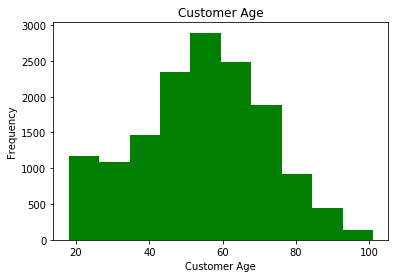

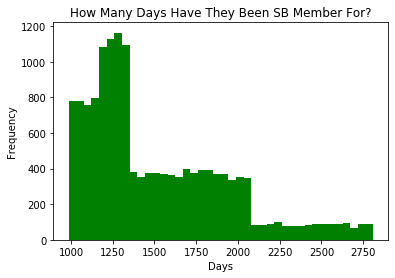

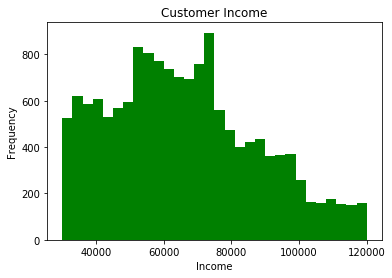

In [79]:
# Plots a Histogram for Starbucks Customers' Age
customerage = cporfile=cleaned_profile.copy()['age'].plot(kind='hist',color='green', bins=10, title='Customer Age')
customerage.set_xlabel("Customer Age")
       
# Plots the nubmer of days a customer has been a loyal member of Star Bucks
plt.figure()
days = cporfile=cleaned_profile.copy()['memberdays'].plot(kind='hist',color='green', bins=40, title='How Many Days Have They Been SB Member For?')
days.set_xlabel("Days")
    
# Display Histogram of User Income
plt.figure()
customerincome = cporfile=cleaned_profile.copy()['income'].plot(kind='hist',color='green', bins=30, title='Customer Income')
customerincome.set_xlabel("Income")

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
# Explore the transcript dataframe to see what data is involved.
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [19]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [20]:
# Investigate on who had the most transctions and explore his journey
transcript.person.value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
5e60c6aa3b834e44b822ea43a3efea26    48
d0a80415b84c4df4908b8403b19765e3    48
                                    ..
e63e42480aae4ede9f07cac49c8c3f78     2
df9fc9a86ca84ef5aedde8925d5838ba     2
912b9f623b9e4b4eb99b6dc919f09a93     2
3045af4e98794a04a5542d3eac939b1f     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

In [21]:
# Explore one person's journey, the one with most transactions
#94de646f7b6041228ca7dec82adb97d2 turns out to be the person with most transactions
transcript[transcript['person']=='94de646f7b6041228ca7dec82adb97d2']

,person,event,value,time
2276,94de646f7b6041228ca7dec82adb97d2,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
16010,94de646f7b6041228ca7dec82adb97d2,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},6
24531,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 7.41},30
24532,94de646f7b6041228ca7dec82adb97d2,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,30
42252,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 1.47},102
55475,94de646f7b6041228ca7dec82adb97d2,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168
75256,94de646f7b6041228ca7dec82adb97d2,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},186
77624,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 2.62},192
81725,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 0.59},204
93913,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 2.2800000000000002},246


In [22]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### More transactions than offer received, this means not all transactions are done through the offers and certainly not after being viewed.  Only 33579 are completed after being viewed.

In [23]:
def clean_transcript(transcriptdf):
    '''
    PURPOSE
    To Return a Dataframe with only offer engagements, and not just any transaction
    
    INPUT:
    The Transcript dataframe we saved earlier in this notebook
    
    OUTPUT:
    A Cleaned Dataframe for Transcript Data
    
    '''

    # Extract the records that are associated with an offer, ignore other transactions that are not associated with offers
    starbucksoffer = transcriptdf[transcriptdf['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) or ('offer%id' in x) else False)]
    
    # extract the offer id from value column
    starbucksoffer['offer_id'] = starbucksoffer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    starbucksoffer.head()
    return starbucksoffer

In [24]:
offer = clean_transcript(transcript)

/Users/yourmaster/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
#confirming the offers data is still valid and the same
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [26]:
offer.shape

(167581, 5)

In [27]:
#Testing to see if we can see all the offer engagements for one person
offer[offer['person']=='b895c57e8cd047a8872ce02aa54759d6']

,event,person,time,value,offer_id
12466,offer received,b895c57e8cd047a8872ce02aa54759d6,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
18030,offer viewed,b895c57e8cd047a8872ce02aa54759d6,6,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
45411,offer completed,b895c57e8cd047a8872ce02aa54759d6,114,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4
123351,offer received,b895c57e8cd047a8872ce02aa54759d6,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
141528,offer viewed,b895c57e8cd047a8872ce02aa54759d6,372,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
163193,offer received,b895c57e8cd047a8872ce02aa54759d6,408,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
195023,offer viewed,b895c57e8cd047a8872ce02aa54759d6,474,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
214104,offer received,b895c57e8cd047a8872ce02aa54759d6,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
225025,offer viewed,b895c57e8cd047a8872ce02aa54759d6,516,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
306506,offer completed,b895c57e8cd047a8872ce02aa54759d6,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4


In [28]:
offer[offer['event']=='offer completed']

,person,event,value,time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4


# Modelling

In [43]:

def create_matrix(starbucksoffer):
    '''
    This will output a matrix for the # of completed offers for customers
    
    INPUT:
    offer and also the output file name that will be saved as a pickle
    Take in a text for picklename
    
    OUTPUT:
    This will output hte matrix that shows the number of completed offers for a particular user and if a file name is present, the matrix will be saved as a pickle file for faster access
    
    '''
    # Row - Person
    # Column - Offer ID
    # This will create the matrix for each offerID if the person has interacted.
    matrix = starbucksoffer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()

    
    # Informational data are not directly impacted with transactional data, so we can analyze buy one get one free and discounts to understand its impacts.
    matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    #Instantiate the variables
    x = 16994
    eventsquence = 3
    # Loop through the rows
    for offer_id in matrix.columns:
        print("Currently Processing Offer: ", offer_id)
        num = 0
        for customer in matrix.index:
            num += 1
            if num % 1000 == 0:
                #Checkpoint To Keep Track of The Process by printing out lines
                print("Processed ", num/x*100, 'Percent')
            #Empty Array
            events = []
            
            for event in starbucksoffer[(starbucksoffer['offer_id']==offer_id) & (starbucksoffer['person']==customer)]['event']:
                events.append(event)
            #Basically checking if it follows all 3 steps, if not then it counts as successful, if no, then do not count towards a successful promotion.
            if len(events) >= eventsquence:
                matrix.loc[customer, offer_id] = 0
                for i in range(len(events)-2):
                    # Checks if this validates with the customer journey, if the customer receives, then views and completes an order, that will qualify as a valid and successful promotion
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        matrix.loc[customer, offer_id] += 1
            elif len(events) >= 1:
                matrix.loc[customer, offer_id] = 0
    
    return matrix

In [44]:
full_df = create_matrix(offer)

Currently Processing Offer:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Processed  5.884429798752501 Percent
Processed  11.768859597505003 Percent
Processed  17.653289396257502 Percent
Processed  23.537719195010006 Percent
Processed  29.422148993762505 Percent
Processed  35.306578792515005 Percent
Processed  41.19100859126751 Percent
Processed  47.07543839002001 Percent
Processed  52.95986818877251 Percent
Processed  58.84429798752501 Percent
Processed  64.7287277862775 Percent
Processed  70.61315758503001 Percent
Processed  76.4975873837825 Percent
Processed  82.38201718253502 Percent
Processed  88.26644698128752 Percent
Processed  94.15087678004002 Percent
Currently Processing Offer:  2298d6c36e964ae4a3e7e9706d1fb8c2
Processed  5.884429798752501 Percent
Processed  11.768859597505003 Percent
Processed  17.653289396257502 Percent
Processed  23.537719195010006 Percent
Processed  29.422148993762505 Percent
Processed  35.306578792515005 Percent
Processed  41.19100859126751 Percent
Processed  47.075

In [47]:
#Save to a Pickle File
filehandler = open('full_df', 'wb')
pickle.dump(full_df,filehandler)
filehandler.close()

In [48]:
index = offer.index
length = len(index)
length

167581

In [49]:
# After getting a a full matrix, we need to split data into train and test data.
# In this case I will get more data for training purpose
train_size = int(length*0.6)
test_size=length - train_size
train_size,test_size

(100548, 67033)

In [50]:
# From 61 - 100%
train_sb_offer = offer[:train_size]
# from 0% - 60%
test_sb_offer = offer[train_size:]

In [52]:
train_df = create_matrix(train_sb_offer)

Currently Processing Offer:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Processed  5.884429798752501 Percent
Processed  11.768859597505003 Percent
Processed  17.653289396257502 Percent
Processed  23.537719195010006 Percent
Processed  29.422148993762505 Percent
Processed  35.306578792515005 Percent
Processed  41.19100859126751 Percent
Processed  47.07543839002001 Percent
Processed  52.95986818877251 Percent
Processed  58.84429798752501 Percent
Processed  64.7287277862775 Percent
Processed  70.61315758503001 Percent
Processed  76.4975873837825 Percent
Processed  82.38201718253502 Percent
Processed  88.26644698128752 Percent
Processed  94.15087678004002 Percent
Currently Processing Offer:  2298d6c36e964ae4a3e7e9706d1fb8c2
Processed  5.884429798752501 Percent
Processed  11.768859597505003 Percent
Processed  17.653289396257502 Percent
Processed  23.537719195010006 Percent
Processed  29.422148993762505 Percent
Processed  35.306578792515005 Percent
Processed  41.19100859126751 Percent
Processed  47.075

In [54]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN


In [55]:
#Save to a Pickle File
filehandler = open('train_df', 'wb')
pickle.dump(full_df,filehandler)
filehandler.close()

In [57]:
test_df = create_matrix(test_sb_offer)

Currently Processing Offer:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Processed  5.884429798752501 Percent
Processed  11.768859597505003 Percent
Processed  17.653289396257502 Percent
Processed  23.537719195010006 Percent
Processed  29.422148993762505 Percent
Processed  35.306578792515005 Percent
Processed  41.19100859126751 Percent
Processed  47.07543839002001 Percent
Processed  52.95986818877251 Percent
Processed  58.84429798752501 Percent
Processed  64.7287277862775 Percent
Processed  70.61315758503001 Percent
Processed  76.4975873837825 Percent
Processed  82.38201718253502 Percent
Processed  88.26644698128752 Percent
Processed  94.15087678004002 Percent
Currently Processing Offer:  2298d6c36e964ae4a3e7e9706d1fb8c2
Processed  5.884429798752501 Percent
Processed  11.768859597505003 Percent
Processed  17.653289396257502 Percent
Processed  23.537719195010006 Percent
Processed  29.422148993762505 Percent
Processed  35.306578792515005 Percent
Processed  41.19100859126751 Percent
Processed  47.075

In [58]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [59]:
#Save to a Pickle File
filehandler = open('test_df', 'wb')
pickle.dump(full_df,filehandler)
filehandler.close()

In [60]:
# Run this cell iif you want to directly import the pickle files to skip the process of matrix creation.

#full_df = pd.read_pickle('matrix.p')

#train_df = pd.read_pickle('train_df.p')

#test_df = pd.read_pickle('test_df.p')

In [102]:
def FunkSingularValueDecomposition(matrix, latent_features, rate_of_learning, iterations):
    '''
    INPUT:
    matrix - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - # of features that wil lbe taken into consideration
    rate_of_learning - the rate of the algorithm learning through the matrices
    iterations - Number of iterations the function will loop through
    
    OUTPUT:
    customer_mat - customers x latent features
    sb_offer_matrix - offer x latent features
    '''

    # Instantiate values to use for later within SVD function
    n_customers = matrix.shape[0]
    n_sb_offer = matrix.shape[1]
    num_complete = np.count_nonzero(~np.isnan(matrix))
    # initialize the user and movie matrices with random values
    customer_matrix = np.random.rand(n_customers, latent_features)
    offers_matrix = np.random.rand(latent_features, n_sb_offer)
    # initialize Error Sum of Squares at 0 for first iteration
    ErrSumSquares = 0
    # for each iteration
    for iteration in range(iterations):

        # For each iteration,  update the SSE
        old_sse = ErrSumSquares
        ErrSumSquares = 0
        
        # For each offer sent to each customer
        for i in range(n_customers):
            for j in range(n_sb_offer):
                
                # In case if the rating does exist
                if matrix[i, j] >= 0:
                    
                    # compute the error as the actual - customer * latent features
                    difference = matrix[i, j] - np.dot(customer_matrix[i, :], offers_matrix[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    ErrSumSquares += difference**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        customer_matrix[i, k] += rate_of_learning * (2*difference*offers_matrix[k, j])
                        offers_matrix[k, j] += rate_of_learning * (2*difference*customer_matrix[i, k])
        print (iteration+1, ErrSumSquares / num_complete)
    return customer_matrix, offers_matrix

In [103]:
# Create user-by-item matrix - nothing to do here
train_data_n1p = np.array(train_df)

#Testing 30 latent features
customer_matrix30, sb_offer_matrix30 = FunkSingularValueDecomposition(train_data_n1p, 30, 0.005, 100)

1 0.36496583921309816
2 0.24624321438893765
3 0.2460452930313068
4 0.2458206143749835
5 0.2455877891949157
6 0.24534725629151782
7 0.24509853262294248
8 0.24484107882716352
9 0.24457431924882855
10 0.24429764032608767
11 0.2440103883259424
12 0.24371186696917965
13 0.2434013349624034
14 0.2430780034425343
15 0.24274103334094418
16 0.24238953267652416
17 0.2420225537898063
18 0.241639090533405
19 0.24123807543744108
20 0.2408183768729551
21 0.2403787962406836
22 0.2399180652179691
23 0.23943484310229268
24 0.23892771429642176
25 0.23839518598726506
26 0.23783568607834027
27 0.2372475614441097
28 0.23662907658349372
29 0.23597841275932951
30 0.2352936677204434
31 0.234572856113081
32 0.23381391069854593
33 0.23301468450357168
34 0.23217295403910015
35 0.23128642373101332
36 0.23035273171250661
37 0.22936945713173987
38 0.22833412912907664
39 0.227244237635121
40 0.22609724613266746
41 0.22489060651204815
42 0.2236217761286578
43 0.22228823714337242
44 0.22088751818974187
45 0.21941721836

In [104]:
# testing 20 latent features
customer_matrix20, sb_offer_matrix20  = FunkSingularValueDecomposition(train_data_n1p, 20, 0.005, 100)

1 0.3240707726289952
2 0.24214864363007949
3 0.241936791496236
4 0.2417076402978741
5 0.2414729267564122
6 0.24123285258612218
7 0.24098705946879956
8 0.24073515232139203
9 0.24047670873243607
10 0.24021127747778273
11 0.2399383767390547
12 0.23965749223800417
13 0.23936807529227017
14 0.23906954079526208
15 0.23876126512429394
16 0.23844258398257154
17 0.23811279018253198
18 0.2377711313800805
19 0.23741680777171711
20 0.2370489697693009
21 0.23666671567027586
22 0.2362690893447479
23 0.23585507796473887
24 0.23542360980520347
25 0.23497355215138455
26 0.23450370935217468
27 0.2340128210649506
28 0.2334995607434586
29 0.23296253442680523
30 0.2324002798943901
31 0.23181126625869714
32 0.23119389407484264
33 0.23054649605288155
34 0.2298673384654965
35 0.22915462334982117
36 0.2284064916074897
37 0.22762102711082358
38 0.22679626192557825
39 0.2259301827606445
40 0.22502073875264902
41 0.22406585068754636
42 0.2230634217515946
43 0.22201134989002047
44 0.22090754183246064
45 0.21974992

In [106]:
#Testing 10 Latent features
customer_matrix10, sb_offer_matrix10 = FunkSingularValueDecomposition(train_data_n1p, 10, 0.005, 100)

1 0.2663592445458609
2 0.24008359991528225
3 0.23977670037236545
4 0.23945384682247606
5 0.23912838570766537
6 0.2388006030198229
7 0.23847035984369302
8 0.2381374974344073
9 0.23780184582444647
10 0.23746322332622233
11 0.237121435789726
12 0.23677627581459576
13 0.23642752191983632
14 0.23607493767015716
15 0.23571827075791563
16 0.2353572520399547
17 0.23499159452871698
18 0.2346209923374927
19 0.2342451195798808
20 0.23386362922402798
21 0.23347615190279397
22 0.2330822946814347
23 0.23268163978525291
24 0.2322737432903439
25 0.23185813378159353
26 0.23143431098307443
27 0.23100174436721344
28 0.23055987175047815
29 0.2301080978848379
30 0.2296457930559677
31 0.2291722917010782
32 0.22868689106133255
33 0.22818884988608365
34 0.2276773872087219
35 0.22715168121658325
36 0.22661086824022858
37 0.22605404189050454
38 0.22548025237500127
39 0.22488850602878024
40 0.2242777650976213
41 0.22364694781547256
42 0.2229949288208573
43 0.2223205399602624
44 0.22162257152907683
45 0.220899774

In [179]:
def OfferEngagementPred(user_matrix, offer_matrix, CustomerID, OfferID):
    '''
    This function is used to predict customer enagement with various offers such as BOGO and discount
    
    INPUT:
    user_matrix - customer x latent feature
    offer_matrix - offers x latent features
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        #Loop breaks if it does nto meet the below procedures
        UserList = np.array(train_df.index)
        OfferList = np.array(train_df.columns)
        UserRow = np.where(UserList == CustomerID)[0][0]
        OfferColumn = np.where(OfferList == OfferID)[0][0]
        Prediction = np.dot(user_matrix[UserRow, :], offer_matrix[:, OfferColumn])
        
        return Prediction
    
    except:
        return None

In [180]:
test_df

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
fff7576017104bcc8677a8d63322b5e1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0
fff8957ea8b240a6b5e634b6ee8eafcf,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [187]:
def validation(df, CustomerMatrix, OfferMatrix):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse = 0
    
    for UID in df.index:
        for OID in df.columns:
            if ~np.isnan(df.loc[UID, OID]):
                ValuePrediction = OfferEngagementPred(CustomerMatrix, OfferMatrix, UID, OID)
                if ValuePrediction != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    difference = df.loc[UID, OID] - OfferEngagementPred(CustomerMatrix, OfferMatrix, UID, OID)

                    # Keep track of the sum of squared errors for the matrix
                    sse += difference**2
    
    print(sse / num_complete)

In [188]:
# Evaluation for latent features of 30
validation(test_df, customer_matrix30, sb_offer_matrix30)

0.31036870719254717


In [189]:
# Evaluation for latent features of 20
validation(test_df, customer_matrix20, sb_offer_matrix20)

0.2809705923028629


In [190]:
# Evaluation for latent features of 10
validation(test_df, customer_matrix10, sb_offer_matrix10)

0.2594563722555836


#### From the above, we can see that the test data with 10 latent features is the most suitable as it has a lower error rate.

In [268]:
def TopOffer(matrix):
    # Find out which offer sells the best

    OfferList = []
    for offer_id in matrix.columns:
        OfferList.append([offer_id, transcript[(transcript['person'].isin(list(matrix[matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    Offertext = pd.DataFrame(OfferList, columns=['Offer ID', 'Transaction'])
    Offertext['Transaction'] = pd.to_numeric(Offertext['Transaction'])
    Offertext.sort_values(by='Transaction', ascending=False, inplace=True)
    
    topoffer = Offertext.plot.pie(y='Transaction', figsize=(10, 10))
    
    return Offertext

,Offer ID,Transaction
7,fafdcd668e3743c1bb461111dcafc2a4,204496.46
1,2298d6c36e964ae4a3e7e9706d1fb8c2,199298.38
6,f19421c1d4aa40978ebb69ca19b0e20d,174239.71
3,4d5c57ea9a6940dd891ad53e9dbe8da0,163633.80
5,ae264e3637204a6fb9bb56bc8210ddfd,140705.68
2,2906b810c7d4411798c6938adc9daaa5,105244.84
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,104574.55
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,66468.11


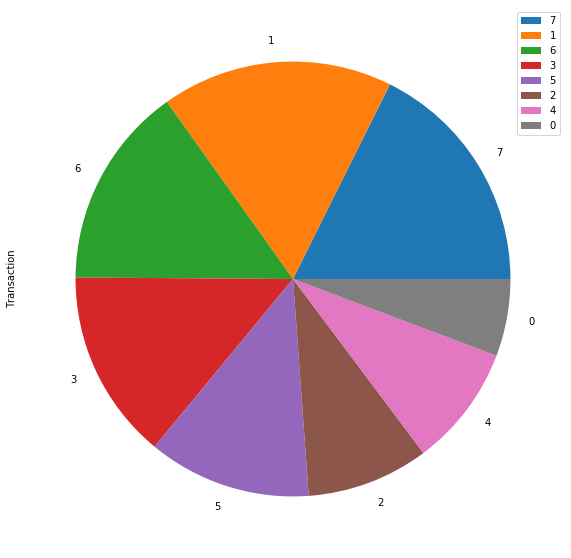

In [269]:
TopOffer(test_df)

In [278]:
def RecommendationEngine(customer_id, customer_matrix, offer_matrix):
    """
    This will output a offer recommendation for a specific user based on its history of engagements with certain promotions whether its BOGO or Discount
    
    input
    The df with the right latent features
    
    output
    Recommends a Starbucks offer
    """
    Rec = {}
    for OID in test_df.columns:
        ValuePrediction = OfferEngagementPred(customer_matrix, offer_matrix, customer_id, OID)
        if ValuePrediction != None:
            Rec[OID] = ValuePrediction
        else:
            break
    #if the user doenst exist or there are no recommendations, trigger TopOffer method to offer default
    if ValuePrediction == None:
        print("The user does not exist in this database, we should offer the highest engagement offer")
        TopOffer(test_df)

    else:
        print("recommend offer for user ", customer_id)
        for OID, ValuePrediction in sorted(Rec.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", OID, " predicted value: ", round(ValuePrediction,4))

In [279]:
# Choose a random user from the above 
RecommendationEngine('0610b486422d4921ae7d2bf64640c50b', customer_matrix30, sb_offer_matrix30)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.9908
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.8043
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.6714
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.5204
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.4012
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.1791
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.1441
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  -0.5063


The user does not exist in this database, we should offer the highest engagement offer


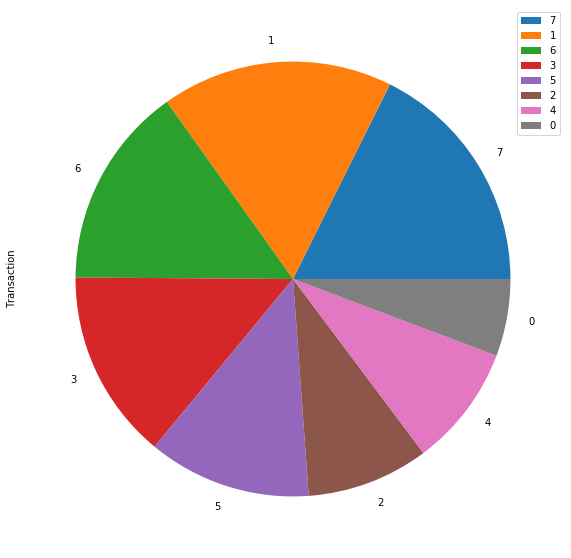

In [281]:
#Testing a complete new user OR someone who doesnt exist OR when we dont have any recommendation available
RecommendationEngine('newuser121345651123', customer_matrix10, sb_offer_matrix10)

In [401]:
#This will create dataframe for the responses from customers
Response = pd.DataFrame(data=[[0,0],[0,0]], index=['M', 'F'], columns=['bogo', 'discount'])
#This will create  empty dataframe for offers Sent Out
Sent = pd.DataFrame(data=[[0,0],[0,0]], index=['M', 'F'], columns=['bogo', 'discount'])

In [402]:

def OfferGender(fulldataframe, R, S,): 

    # We count the number of offer completed based on the customer gender
    for OT in ['bogo', 'discount']:
        for OID in portfolio[portfolio['offer_type']==OT]['id']:
            # Total number of responses
            R[OT] = R[OT].add(profile[profile['id'].isin(fulldataframe[fulldataframe[OID]>0].index)]['gender'].value_counts(),fill_value=0)
            # Total Number of offers sent
            S[OT] = S[OT].add(profile[profile['id'].isin(fulldataframe[fulldataframe[OID]>-1].index)]['gender'].value_counts(),fill_value=0)
    S
    R
    mycolor = list('rgbkymc')
    Offer = (R / S * 100).plot(kind='bar',color=mycolor, title='Percentage of customer response')

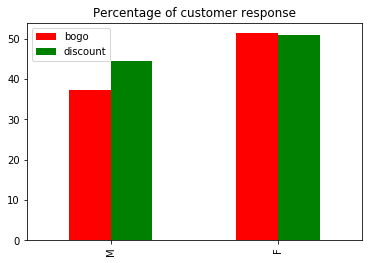

In [403]:
OfferGender(full_df, Response, Sent)

Verifying numbers below

In [366]:
Sent

,bogo,discount
M,12662,12706
F,9097,9110
O,303,303


In [367]:
Response

,bogo,discount
M,4730,5637
F,4675,4639
O,172,175


In [391]:
    # initialize the gender response and the gender sent dataframe
    ChannelResponse = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0]], index=['M', 'F'], columns=['web', 'email', 'mobile', 'social'])
    ChannelOffersSent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0]], index=['M', 'F'], columns=['web', 'email', 'mobile', 'social'])

In [396]:
def gender_offer_channel(df, R, S):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    # We count the number of offer completed base on the customer gender
    for CT in ['web', 'email', 'mobile', 'social']:
        for OID in portfolio_clean[(portfolio_clean[CT]==1)&(portfolio_clean['informational']!=1)]['id']:
            # Total number of responses
            R[CT] = R[CT].add(profile[profile['id'].isin(df[df[OID]>0].index)]['gender'].value_counts(), fill_value=0)
            # Total number of Sent Offers
            S[CT] = S[CT].add(profile[profile['id'].isin(df[df[OID]>=0].index)]['gender'].value_counts(), fill_value=0)
    mycolor = list('rgbkymc')
    gender_offer = (R / S * 100).plot(kind='bar',color=mycolor, title='Percentage of customer response')

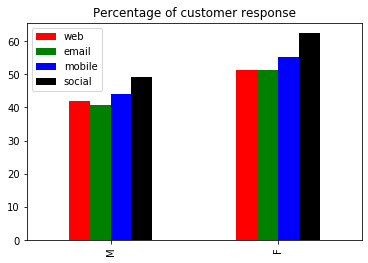

In [397]:
gender_offer_channel(full_df,ChannelResponse , ChannelOffersSent)

## Medium Blog Post Link : https://unstoppablebird.medium.com/the-starbucks-offer-you-crave-most-cff74a9e5739